# Titanic survival prediction

## 1. Introduction
In this proyect we build a predictive model that, given Titanic's passengers data (ie name, age, gender, socio-economic class, etc) is able to predict whether these passengers survived or not.

This proyect is part of a [kaggle's competition](https://www.kaggle.com/c/titanic/overview).


### Datasets
We will handle two different datasets:
- *train.csv*: It contains information about passengers and also a column indicating wheter they survived or not.

- *test.csv*: It is similar to the previous dataset, but it does not contain the column with survival information.

Our task is to give back the survival information for passengers whose information is given in the *test.csv* dataset.

### 1.1 Dataset features
The datasets contain the following features:

- passergerId:  Unique Id for each passenger
- survived:     1 = the passenger survived, 0 = the passenger did not survive (only in the train dataset)
- name:         Passenger name
- pclass:	    Ticket class	(1 = 1st, 2 = 2nd, 3 = 3rd)
- sex:	        Sex	
- Age:	        Age in years	
- sibsp:	    # of siblings / spouses aboard the Titanic	
- parch:	    # of parents / children aboard the Titanic	
- ticket:	    Ticket number	
- fare:	        Passenger fare	
- cabin:	    Cabin number	
- embarked:	    Port of Embarkation	(C = Cherbourg, Q = Queenstown, S = Southampton)

### 1.2 Methodology
We will perform an EDA to get to know the data and we will create a predictive model based on supervised machine learning algorithms to make our predictions.

### 1.3 Import libraries and datasets

In [1]:
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import BinaryCrossentropy

from utils import *


import warnings
warnings.simplefilter('ignore')

In [2]:
# load datasets
df_train_original = pd.read_csv('data/train.csv')
df_test_original = pd.read_csv('data/test.csv')


## 2. Exploratory Data Analysis

### 2.1 General features

In [3]:
def general_info(data, title: str):
    print('\033[1m', title, '\033[0m')
    print('-----------------------------------------------')
    print('Shape:', data.shape)
    print('Columns:', ', '.join([feature for feature in data.columns]))
    print('Duplicates:', sum(data.duplicated()))
    print('')

In [4]:

general_info(df_train_original, 'Train dataset')
general_info(df_test_original, 'Test dataset')


 Train dataset 
-----------------------------------------------
Shape: (891, 12)
Columns: PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked
Duplicates: 0

 Test dataset 
-----------------------------------------------
Shape: (418, 11)
Columns: PassengerId, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked
Duplicates: 0



In [5]:
df_train_original.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
df_test_original.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


We inspect datatypes and null values

In [7]:
df_train_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


There are some missing ages and many missing values in "Cabin". There are two missing "Embarked" values.

In [8]:
df_test_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


As in the train dataset, we observe some missing values in age and many missing values in Cabin. There is also one missing fare.

In [9]:
# Number of unique values
df_train_original.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

### 2.2 Statistic values

In [10]:
df_train_original.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
df_test_original.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


We observe similar values in the statistical parameters of both datasets

### 2.3 Survivals set

We inspect survivals ratio to see if the results are skewed

In [12]:
def print_percentage(data, column_name: str, order, axis=None, x_shift=0, y_shift=0.02):
    '''
   This function is to be used below a count plot. 
   It prints the percentage on the bars of vertical countplots
   '''
    val_counts = data[column_name].value_counts().loc[order]
    total_counts = val_counts.sum()
    max_count = val_counts.sort_values(ascending=False).iloc[0]

    for i, count in enumerate(val_counts):
        pct_string = f'{100*count/total_counts:.1f}%'

        if not axis:
            plt.text(i + x_shift, count + y_shift *
                     max_count, pct_string, va='center', ha='center')
        else:
            axis.text(i + x_shift, count + y_shift *
                      max_count, pct_string, va='center', ha='center')



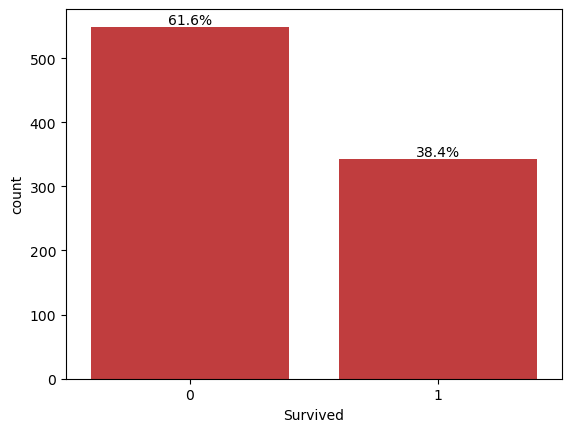

In [13]:
order = df_train_original.Survived.value_counts().sort_index().index

sns.countplot(data=df_train_original, x='Survived', order= order, color='tab:red')
print_percentage(data=df_train_original, column_name='Survived', order=order)

They are not strongly skewed

In [14]:
# Create a new dataset with the information of survivals
df_train_surv = df_train_original[df_train_original['Survived'] == 1]
df_train_surv.shape

(342, 12)

We observe some general properties of survivals set

In [15]:
df_train_surv.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,342.000000,342.0,342.000000,290.000000,342.000000,342.000000,342.000000
mean,444.368421,1.0,1.950292,28.343690,0.473684,0.464912,48.395408
std,252.358840,0.0,0.863321,14.950952,0.708688,0.771712,66.596998
min,2.000000,1.0,1.000000,0.420000,0.000000,0.000000,0.000000
25%,250.750000,1.0,1.000000,19.000000,0.000000,0.000000,12.475000
50%,439.500000,1.0,2.000000,28.000000,0.000000,0.000000,26.000000
75%,651.500000,1.0,3.000000,36.000000,1.000000,1.000000,57.000000
max,890.000000,1.0,3.000000,80.000000,4.000000,5.000000,512.329200


In [16]:
df_train_original.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [17]:
df_train_surv.info()


<class 'pandas.core.frame.DataFrame'>
Index: 342 entries, 1 to 889
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  342 non-null    int64  
 1   Survived     342 non-null    int64  
 2   Pclass       342 non-null    int64  
 3   Name         342 non-null    object 
 4   Sex          342 non-null    object 
 5   Age          290 non-null    float64
 6   SibSp        342 non-null    int64  
 7   Parch        342 non-null    int64  
 8   Ticket       342 non-null    object 
 9   Fare         342 non-null    float64
 10  Cabin        136 non-null    object 
 11  Embarked     340 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 34.7+ KB


### 2.4 Variables comparison between datasets

In this section we will compare the data in the three datasets. There are three purposes for this: the first one is to get to know the training set. The second is to find important features for survival for a possible future feature engineering or features simplification. And finally we also want to check if the test set provided is representative of the training set. 

#### 2.4.1 Unknown values

Let's compare the ratio of missing values in the different datasets

In [18]:
def isna_ratio(data, column: str):
    '''This function calculates the ration of missing values in a column of a dataframe'''
    return sum(data[column].isna()) / data.shape[0]

In [19]:

print('\033[1m Unknown cabin ratios \033[0m')
print('Train set: ', isna_ratio(data=df_train_original, column='Cabin'))
print('Survivals set: ', isna_ratio(df_train_surv, 'Cabin'))
print('Test set: ', isna_ratio(df_test_original, 'Cabin'))
print('')
print('\033[1m Unknown ages ratio \033[0m')
print('Train set: ', isna_ratio(df_train_original, 'Age'))
print('Survivals set: ', isna_ratio(df_train_surv, 'Age'))
print('Test set: ', isna_ratio(df_test_original, 'Age'))

 Unknown cabin ratios 
Train set:  0.7710437710437711
Survivals set:  0.6023391812865497
Test set:  0.7822966507177034

 Unknown ages ratio 
Train set:  0.19865319865319866
Survivals set:  0.15204678362573099
Test set:  0.20574162679425836


The ratio of unknown cabin numbers is similar for the original and test datasets, but it's double for the survivals dataset. A possible explanation for this is that survivals were alive to tell the number of their cabin after the accident.

The ratio of ages is slightly smaller in the survivals dataset, maybe for the same reason than above, but in general is similar for the three datasets.

>**The feature of known/Unknown cabin number and known/Unknown age might be interesting for the prediction**

#### 2.4.2 Social class

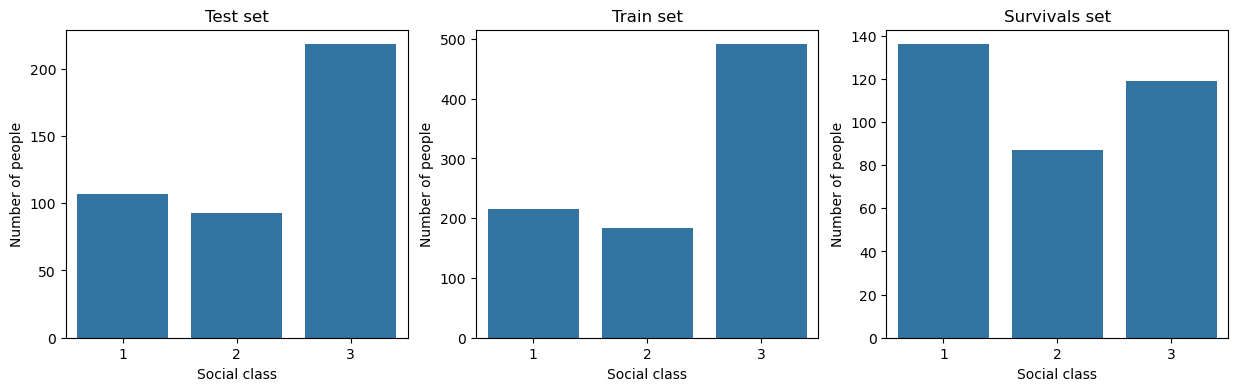

In [20]:
# Datasets to compare and plot titles
datasets=[df_test_original, df_train_original, df_train_surv]
titles=['Test set', 'Train set', 'Survivals set']

# Create the plot for the three datasets
fig, ax = plt.subplots(1, 3, figsize=[15, 4])

for i, dataset in enumerate(datasets):
    sns.countplot(data=dataset, x='Pclass', order=[1, 2, 3], color='tab:blue', ax=ax[i])
    ax[i].set_ylabel('Number of people')
    ax[i].set_xlabel('Social class')
    ax[i].set_title(titles[i]);

Social class seem to be a very important feature for survival

In [21]:
df_train_original_mod.head(2)

NameError: name 'df_train_original_mod' is not defined

#### 2.4.3 Age

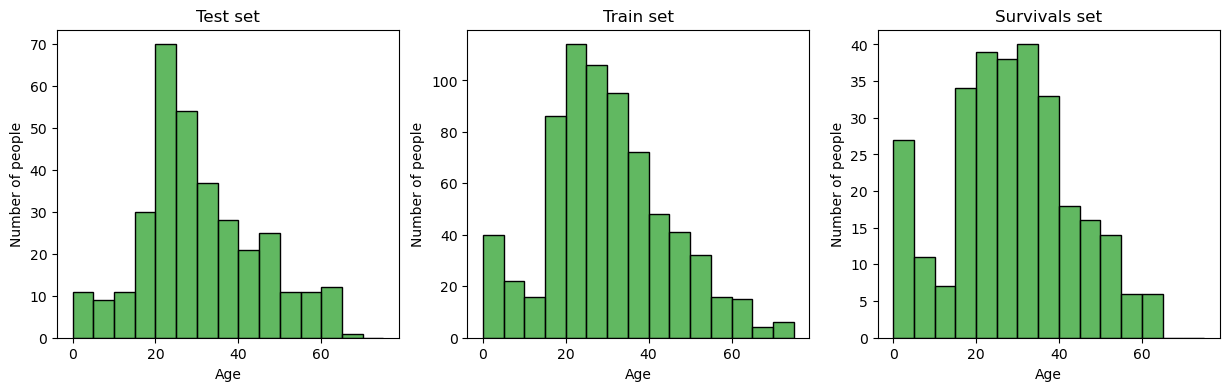

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=[15, 4])
bins = np.arange(0, 80, 5)

for i, dataset in enumerate(datasets):

    sns.histplot(data=dataset, x='Age', color='tab:green', bins=bins, ax=ax[i])
    ax[i].set_ylabel('Number of people')
    ax[i].set_xlabel('Age')
    ax[i].set_title(titles[i]);


Age is an important feature for survival. We observe higher survival rate in children and also in ages between 15 and 40.

We see some differences in the age distribution of the test set and the training set.
It is important to note that in the test set the ratio of childen and people in their 30s are smaller, and so should be the survival rate.

#### 2.4.4 Fare

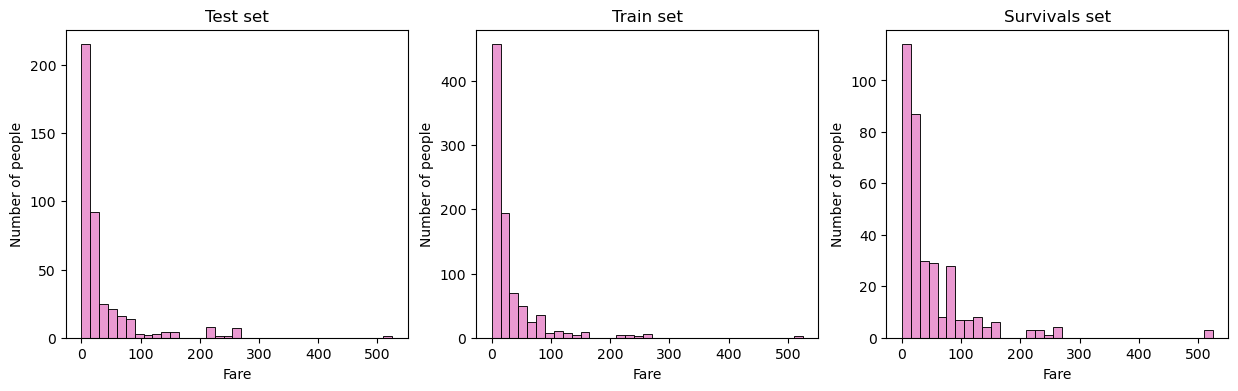

In [ ]:
max_fare = df_train_original.Fare.max()
bins = np.arange(0, max_fare + 15, 15)

fig, ax = plt.subplots(1, 3, figsize=[15, 4])

for i, dataset in enumerate(datasets):

    sns.histplot(data=dataset, x='Fare', color='tab:pink', bins=bins, ax=ax[i])
    ax[i].set_ylabel('Number of people')
    ax[i].set_xlabel('Fare')
    ax[i].set_title(titles[i]);

The train and the test set are similar, but in this plot is not so easy to see the influence of fare in survival. 

We will create a different plot to see the influence of age and fare in survival.

In [ ]:
# Change the survived column from one-hot to Yes/No
df_train_original_mod = df_train_original.copy()
df_train_original_mod['Survived'] = df_train_original['Survived'].replace({1: 'Yes', 0: 'No'})
df_train_original_mod.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,No,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,Yes,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,Yes,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


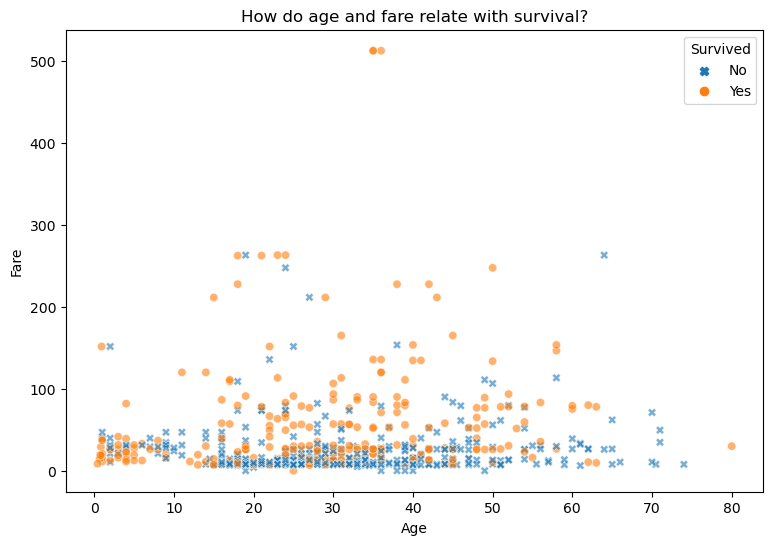

In [ ]:
# Create a scatterplot
fig = plt.figure(figsize=[9, 6])
markers = {'Yes':'o', 'No':'X'}
sns.scatterplot(data=df_train_original_mod, x='Age', y='Fare', alpha=0.6, hue='Survived', style='Survived', markers=markers)
plt.title('How do age and fare relate with survival?');

We will take a closer look at the low fares

(7.0, 15.0)

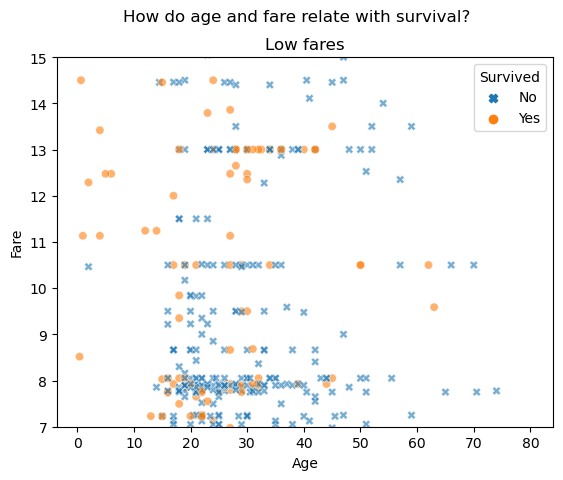

In [ ]:
markers = {'Yes':'o', 'No':'X'}
sns.scatterplot(data=df_train_original_mod, x='Age', y='Fare', alpha=0.6, hue='Survived', style='Survived', markers=markers)
plt.suptitle('How do age and fare relate with survival?');
plt.title('Low fares')
plt.ylim(7, 15)

We see that children were more likely to survive, but **in general fare is more determinant than age for survival.**

#### 2.4.5 Embarked

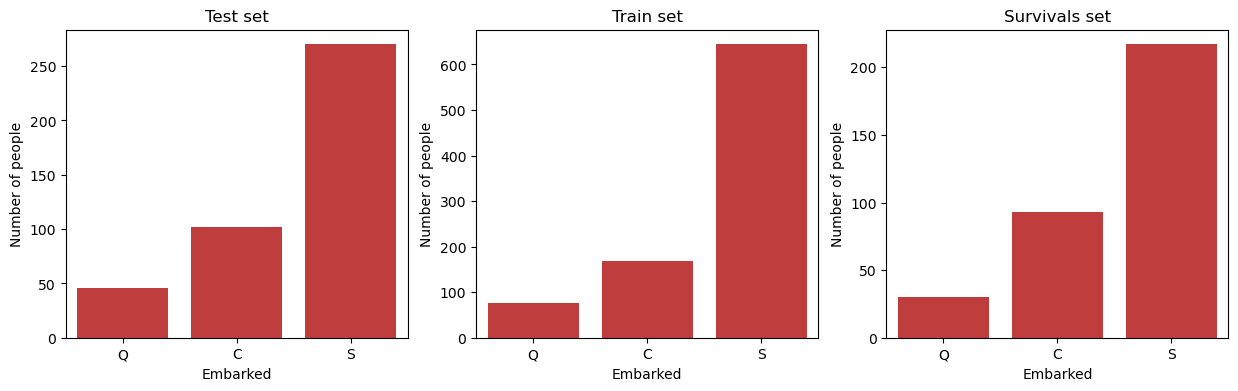

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=[15, 4])
order=df_train_original.Embarked.value_counts().sort_values().index

for i, dataset in enumerate(datasets):
    sns.countplot(data=dataset, x='Embarked', color='tab:red', order=order, ax=ax[i])
    ax[i].set_ylabel('Number of people')
    ax[i].set_xlabel('Embarked')
    ax[i].set_title(titles[i]);
    

There are no reasons to think that embarking place is important for survival. But the plot above show a small difference in the distribution.

To explore this difference we will divide by the number of people in each dataset

In [ ]:
print('\033[1m Train set \033[0m')
print(df_train_original.Embarked.value_counts().sort_index() / df_train_original.shape[0])
print('')
print('\033[1m Survivals set \033[0m')
print(df_train_surv.Embarked.value_counts().sort_index() / df_train_surv.shape[0])

 Train set 
Embarked
C    0.188552
Q    0.086420
S    0.722783
Name: count, dtype: float64

 Survivals set 
Embarked
C    0.271930
Q    0.087719
S    0.634503
Name: count, dtype: float64


We see a slightly bigger survival tendency in Southampton embarked people than people embarked in Cherbourg. We do not know if this just casuality or if there is some relation.

>**We will have to explore how embarking information affects the accuracy in the predictions by the models**

#### 2.4.6 Number of spouses/siblings

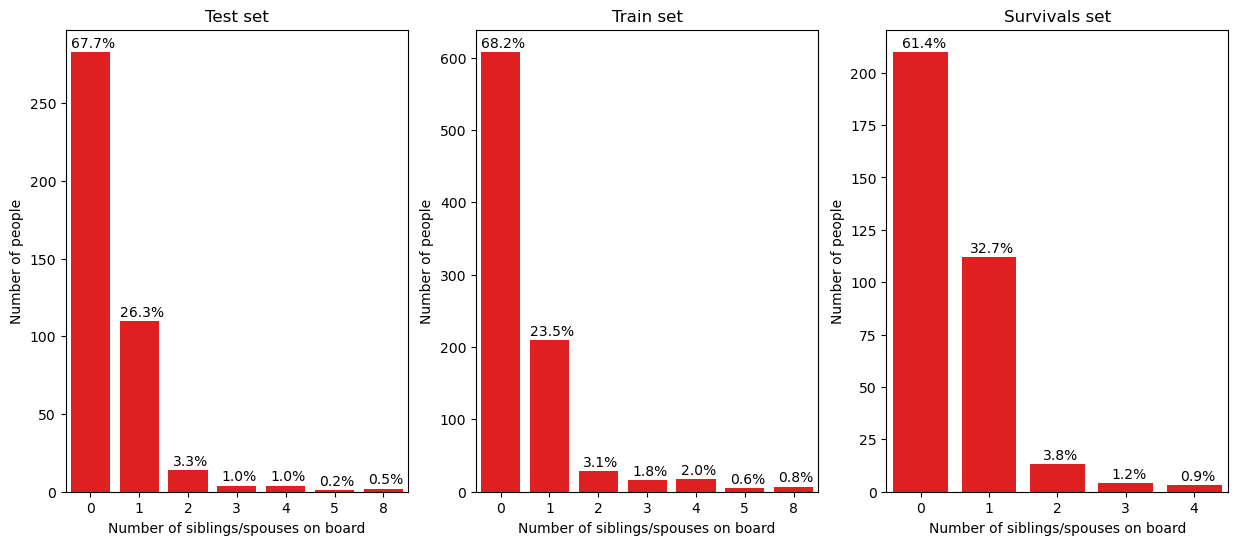

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=[15, 6])

for i, dataset in enumerate(datasets):
    order= dataset.SibSp.value_counts().sort_index().index
    sns.countplot(data=dataset, x='SibSp', color='red', ax=ax[i])
    ax[i].set_ylabel('Number of people')
    ax[i].set_xlabel('Number of siblings/spouses on board')
    ax[i].set_title(titles[i]);
    print_percentage(data=dataset, column_name='SibSp', order=order, axis=ax[i], x_shift=0.05)

We see that test and training sets have similar distributions, but it is hard to tell the behaviour on survival. We create a different plot for that.

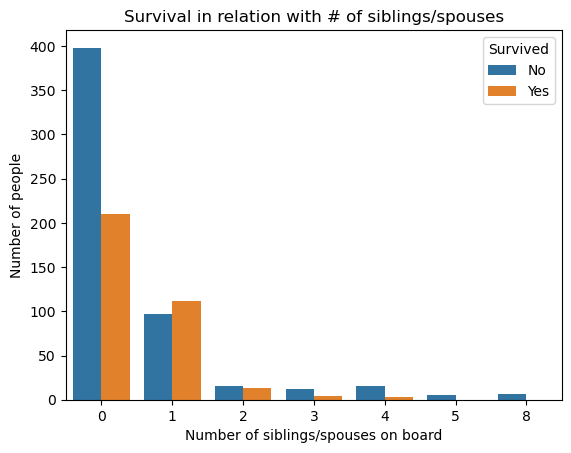

In [ ]:
sns.countplot(data=df_train_original_mod, x='SibSp', hue='Survived')
plt.xlabel('Number of siblings/spouses on board')
plt.ylabel('Number of people')
plt.title('Survival in relation with # of siblings/spouses');


We see different impact on survival in the different categories. Having one or two children/parents on board helped survival, but having more or having none did not help survival.

>**For our model we should split this parameter in categories rather than using it as a continuous variable.**

### 2.4.7 Parents/children

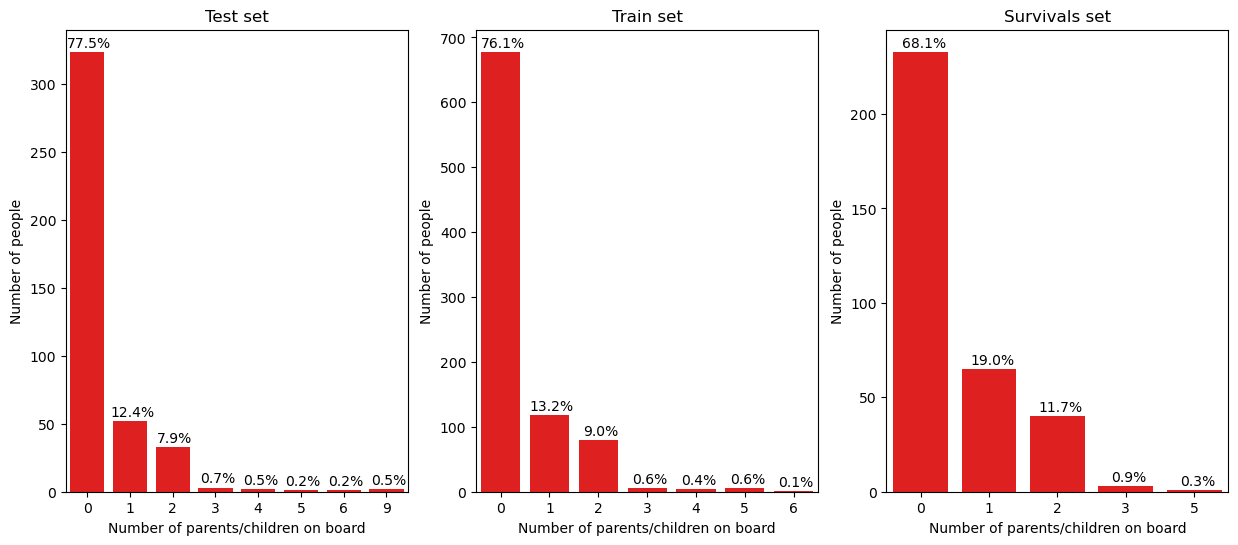

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=[15, 6])


for i, dataset in enumerate(datasets):
    order = dataset['Parch'].value_counts().sort_index().index
    sns.countplot(data=dataset, x='Parch', color='red', ax=ax[i])
    ax[i].set_ylabel('Number of people')
    ax[i].set_xlabel('Number of parents/children on board')
    ax[i].set_title(titles[i]);
    print_percentage(data=dataset, column_name='Parch', order=order, axis=ax[i], x_shift=0.05)

We see that test and training sets have similar distributions, but it is hard to tell the efect of this variable on survival. We create a different plot for that.

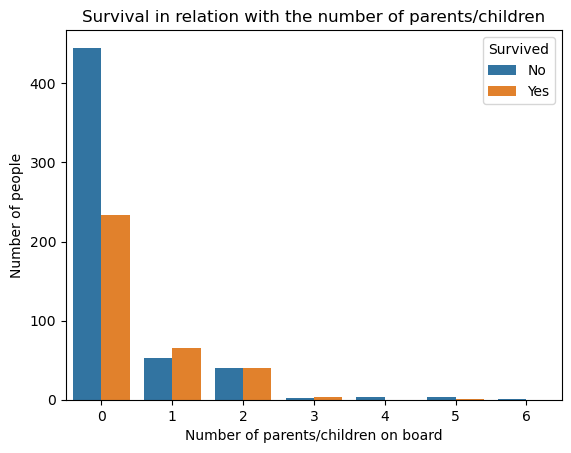

In [ ]:
sns.countplot(data=df_train_original_mod, x='Parch', hue='Survived')
plt.xlabel('Number of parents/children on board')
plt.ylabel('Number of people')
plt.title('Survival in relation with the number of parents/children');

We see different impact on survival in the different categories. Having one, two or three children/parents on board helped survival, but having more or having none did not help survival.

>**For our model we should split this parameter in categories rather than using it as a continuous variable.**

### 2.4.8 Sex

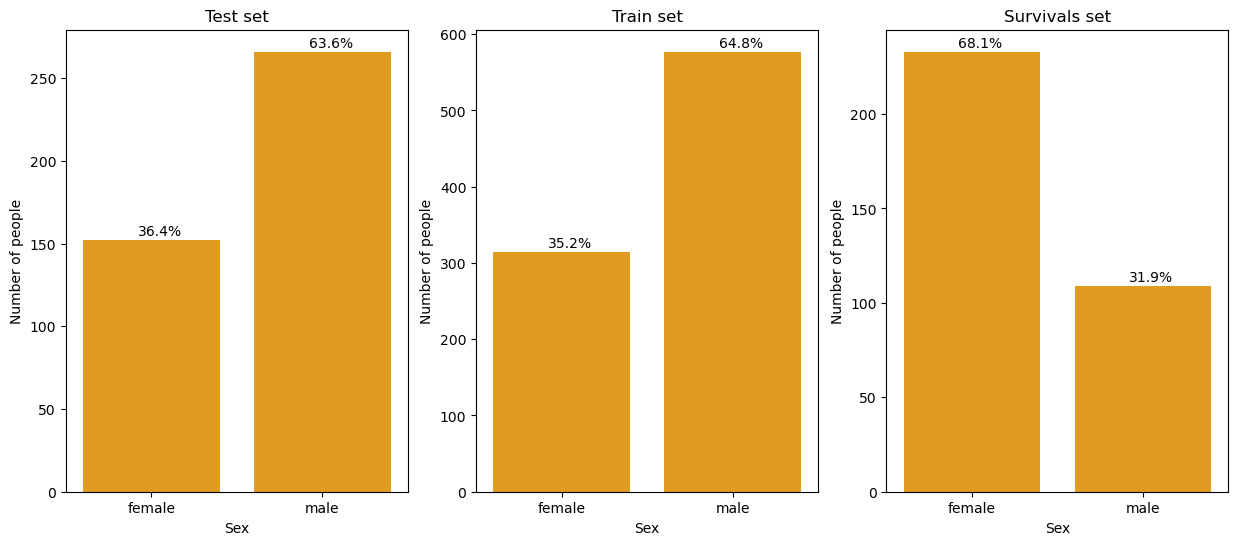

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=[15, 6])
order = dataset['Sex'].value_counts().index

for i, dataset in enumerate(datasets):
    
    sns.countplot(data=dataset, x='Sex', order=order, color='orange', ax=ax[i])
    ax[i].set_ylabel('Number of people')
    ax[i].set_title(titles[i]);
    print_percentage(data=dataset, column_name='Sex', order=order, axis=ax[i], x_shift=0.05)

**Sex was determinant for survival**

## 3. Data preprocesing and feature engineering

We will perform the same procesing in the train and test sets

In [ ]:
# We create a copy of the original dataset
df_train = df_train_original.copy()
df_test = df_test_original.copy()

There are some columns that do not provide significative information for the survival. 

**We drop Name, Embarked and Ticket columns**

In [ ]:
no_significative_cols = ['Name','Embarked', 'Ticket']
df_train = df_train.drop(columns=no_significative_cols)
df_test = df_test.drop(columns=no_significative_cols)

**We create a column for known/unknown age**

In [ ]:
df_train['Unknown_age'] = df_train.Age.isna()
df_test['Unknown_age'] = df_test.Age.isna()

**We fill NaN values found in 'Age' with the mean**

In [ ]:
mean_age = df_train.Age.mean()
df_train['Age'] = df_train.Age.fillna(mean_age)
df_test['Age'] = df_test.Age.fillna(df_test.Age.mean())

**We fill NaN values with unknown in the Cabin column and keep only the letter of the Cabin**

In [ ]:
# Function to keep only the first character of a string
def mantener_primera_letra(texto):
    if texto == 'Unknown':
        return texto
    else:
        return texto[0] if texto else texto

In [ ]:
# We fill NaN values in Cabin with 'U' for 'Unknown'
df_train.Cabin.fillna('Unknown', inplace=True)
df_test.Cabin.fillna('Unknown', inplace=True)

# We keep only the letter of the cabin number
df_train['Cabin'] = df_train.Cabin.apply(lambda x: mantener_primera_letra(x))
df_test['Cabin'] = df_test.Cabin.apply(lambda x: mantener_primera_letra(x))

In [ ]:
# We check the changes were succesfull
df_train.Cabin.value_counts()

Cabin
Unknown    687
C           59
B           47
D           33
E           32
A           15
F           13
G            4
T            1
Name: count, dtype: int64

**We write the categorical features in one-hot notation**

In [ ]:
# List of categorical features
cat_cols = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Cabin']

# Translate to one-hot notation
df_train = pd.get_dummies(data=df_train, prefix=cat_cols, columns=cat_cols)
df_test = pd.get_dummies(data=df_test, prefix=cat_cols, columns=cat_cols)

In [ ]:
df_train.head(3)

,PassengerId,Survived,Age,Fare,Unknown_age,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,...,Parch_6,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_Unknown
0,1,0,22.0,7.2500,False,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,True
1,2,1,38.0,71.2833,False,True,False,False,True,False,...,False,False,False,True,False,False,False,False,False,False
2,3,1,26.0,7.9250,False,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,True


In [ ]:
# Set PassengerId as index
df_test.set_index('PassengerId', inplace=True)
df_train.set_index('PassengerId', inplace=True)

## Splitting train dataset

In [ ]:
# We split the "Survived" column in a different dataset
y = df_train['Survived']
df_train.drop(columns='Survived', inplace=True)

We split our train dataset in three parts: X_train (for training with 60% of the data), X_cv (for validation with 20% of the data) and X_test (for final testing with 20% of the data)

In [ ]:
X_train, x_, y_train, y_ = train_test_split(df_train, y, test_size=0.4, random_state=123)
X_cv, X_test, y_cv, y_test = train_test_split(x_, y_, test_size=0.5, random_state=321)

print('X_train shape: ', X_train.shape)
print('X_cv shape: ', X_cv.shape)
print('X_test shape: ', X_test.shape)

X_train shape:  (534, 31)
X_cv shape:  (178, 31)
X_test shape:  (179, 31)


## 4. Model: Randomforest

We create a scikit-learn Randomforest model.

We will explore the parameters of the model, starting by the maximum tree depth.

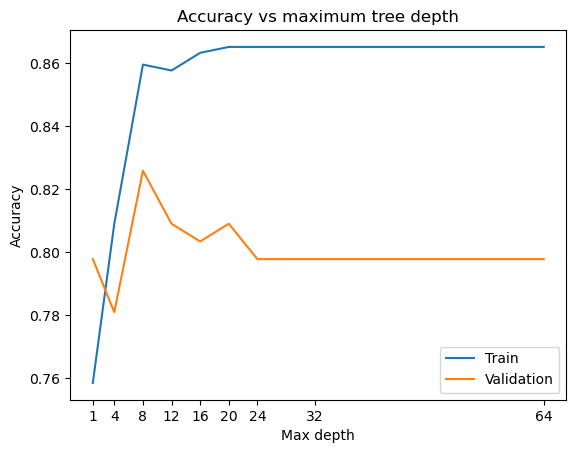

In [ ]:
# Create and train the model
estimators= 75
depth_list = [1, 4, 8, 12, 16, 20, 24, 32, 64]
samples_split = 25

acc_train_list = []
acc_cv_list = []


for depth in depth_list:

    model = RandomForestClassifier(n_estimators=estimators, min_samples_split=samples_split, 
                                max_depth=depth, random_state=1).fit(X_train, y_train)

    # Use the model for predictions in both train and cross validation sets
    y_train_pred = model.predict(X_train)
    y_cv_pred = model.predict(X_cv)

    # Calculate the error
    accuracy_train = accuracy_score(y_train, y_train_pred)
    acc_train_list.append(accuracy_train)
    accuracy_cv = accuracy_score(y_cv, y_cv_pred)
    acc_cv_list.append(accuracy_cv)


plt.plot(depth_list, acc_train_list)
plt.plot(depth_list, acc_cv_list)
plt.xticks(depth_list)
plt.legend(['Train', 'Validation'])
plt.title('Accuracy vs maximum tree depth')
plt.xlabel('Max depth')
plt.ylabel('Accuracy');


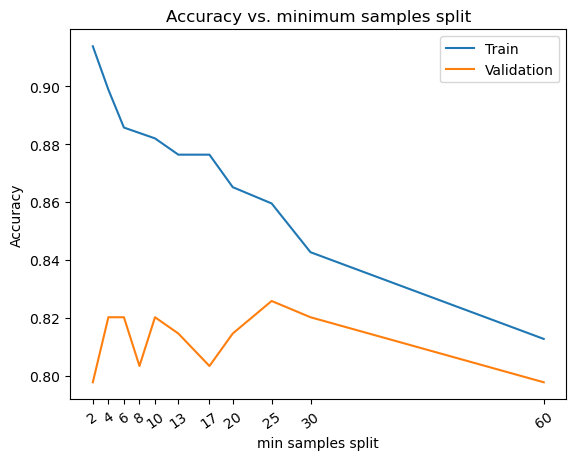

In [ ]:
# Create and train the model for different values of samples split
estimators= 75
depth = 8
samples_split_list = [60, 30, 25, 20, 17, 13, 10,  8, 6, 4, 2]

acc_train_list = []
acc_cv_list = []

for samples_split in samples_split_list:

    model = RandomForestClassifier(n_estimators=estimators, min_samples_split=samples_split, 
                                max_depth=depth, random_state=1).fit(X_train, y_train)

    # Use the model for predictions in both train and cross validation sets
    y_train_pred = model.predict(X_train)
    y_cv_pred = model.predict(X_cv)

    # Calculate the error
    accuracy_train = accuracy_score(y_train, y_train_pred)
    acc_train_list.append(accuracy_train)
    accuracy_cv = accuracy_score(y_cv, y_cv_pred)
    acc_cv_list.append(accuracy_cv)


# Plot the accuracy score
plt.plot(samples_split_list, acc_train_list)
plt.plot(samples_split_list, acc_cv_list)
plt.xticks(samples_split_list, rotation=35)
plt.legend(['Train', 'Validation'])
plt.xlabel('min samples split')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. minimum samples split');



Text(0.5, 1.0, 'Accuracy vs number of estimators')

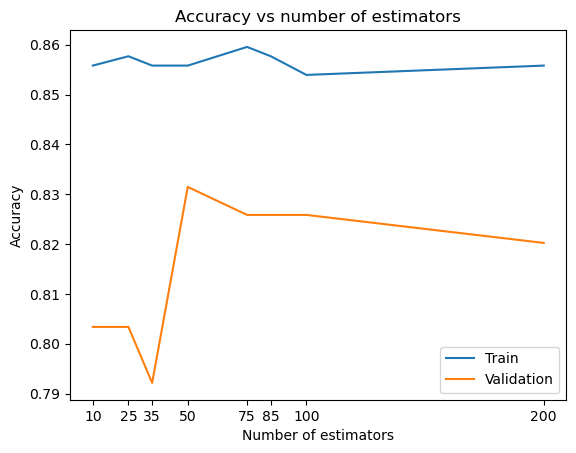

In [ ]:


# Create and train the model
estimators_list= [200, 100, 85, 75, 50, 35, 25, 10]
depth = 8
samples_split = 25

acc_train_list = []
acc_cv_list = []

for estimators in estimators_list:

    model = RandomForestClassifier(n_estimators=estimators, min_samples_split=samples_split, 
                                max_depth=depth, random_state=1).fit(X_train, y_train)

    # Use the model for predictions in both train and cross validation sets
    y_train_pred = model.predict(X_train)
    y_cv_pred = model.predict(X_cv)

    # Calculate the error
    accuracy_train = accuracy_score(y_train, y_train_pred)
    acc_train_list.append(accuracy_train)
    accuracy_cv = accuracy_score(y_cv, y_cv_pred)
    acc_cv_list.append(accuracy_cv)


plt.plot(estimators_list, acc_train_list)
plt.plot(estimators_list, acc_cv_list)
plt.xticks(estimators_list)
plt.legend(['Train', 'Validation'])
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy')
plt.title('Accuracy vs number of estimators')



The best parameters for the randomforest model are: 
- Number of estimators: 50
- Maximum depth: 8
- Minimum samples split: 25

In [ ]:
model = RandomForestClassifier(n_estimators=25, min_samples_split=13, 
                                max_depth= 14, random_state=1).fit(X_train, y_train)

# Use the model for predictions in both train and cross validation sets
y_train_pred = model.predict(X_train)
y_cv_pred = model.predict(X_cv)
y_test_pred = model.predict(X_test)

# Calculate the error
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_cv = accuracy_score(y_cv, y_cv_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

print('Model: RandomForestClassifier:')
print('---------------------------------------------------')
print(f'Accuracy score of the train set: {accuracy_train:.3f}')
print(f'Accuracy score of the validation set: {accuracy_cv:.3f}')
print(f'Accuracy score of the test set: {accuracy_test:.3f}')

Model: RandomForestClassifier:
---------------------------------------------------
Accuracy score of the train set: 0.886
Accuracy score of the validation set: 0.831
Accuracy score of the test set: 0.849


>**The accuracy is quite close in the three datasets. We should explore if there is some bias issue in order to get a better accuracy.**

## 5. Model: XGBoost Classifier

In [ ]:
xgb_model = XGBClassifier(n_estimators = 500, learning_rate = 0.1,verbosity = 1, random_state = 123)
xgb_model.fit(X_train, y_train, eval_set = [(X_cv, y_cv)], early_stopping_rounds = 10)

[0]	validation_0-logloss:0.65023
[1]	validation_0-logloss:0.61616
[2]	validation_0-logloss:0.58679
[3]	validation_0-logloss:0.56003
[4]	validation_0-logloss:0.53940
[5]	validation_0-logloss:0.52406
[6]	validation_0-logloss:0.50741
[7]	validation_0-logloss:0.49477
[8]	validation_0-logloss:0.48302
[9]	validation_0-logloss:0.47359
[10]	validation_0-logloss:0.46618
[11]	validation_0-logloss:0.46009
[12]	validation_0-logloss:0.45292
[13]	validation_0-logloss:0.44723
[14]	validation_0-logloss:0.44202
[15]	validation_0-logloss:0.43993
[16]	validation_0-logloss:0.43640
[17]	validation_0-logloss:0.43338
[18]	validation_0-logloss:0.43186
[19]	validation_0-logloss:0.43112
[20]	validation_0-logloss:0.43070
[21]	validation_0-logloss:0.42715
[22]	validation_0-logloss:0.42537
[23]	validation_0-logloss:0.42356
[24]	validation_0-logloss:0.42065
[25]	validation_0-logloss:0.42067
[26]	validation_0-logloss:0.41923
[27]	validation_0-logloss:0.41921
[28]	validation_0-logloss:0.41913


[29]	validation_0-logloss:0.41998
[30]	validation_0-logloss:0.41994
[31]	validation_0-logloss:0.41914
[32]	validation_0-logloss:0.42006
[33]	validation_0-logloss:0.41755
[34]	validation_0-logloss:0.41816
[35]	validation_0-logloss:0.41839
[36]	validation_0-logloss:0.41706
[37]	validation_0-logloss:0.41791
[38]	validation_0-logloss:0.41827
[39]	validation_0-logloss:0.41704
[40]	validation_0-logloss:0.41857
[41]	validation_0-logloss:0.41933
[42]	validation_0-logloss:0.41966
[43]	validation_0-logloss:0.41836
[44]	validation_0-logloss:0.41847
[45]	validation_0-logloss:0.41878
[46]	validation_0-logloss:0.41784
[47]	validation_0-logloss:0.41713
[48]	validation_0-logloss:0.41722
[49]	validation_0-logloss:0.41596
[50]	validation_0-logloss:0.41705
[51]	validation_0-logloss:0.41619
[52]	validation_0-logloss:0.41647
[53]	validation_0-logloss:0.41725
[54]	validation_0-logloss:0.41694
[55]	validation_0-logloss:0.41685
[56]	validation_0-logloss:0.41682
[57]	validation_0-logloss:0.41660
[58]	validatio

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, ...)

In [ ]:
y_train_pred_xgb = xgb_model.predict(X_train)
y_cv_pred_xgb = xgb_model.predict(X_cv)
y_test_pred_xgb = xgb_model.predict(X_test)

accuracy_train_xgb = accuracy_score(y_train, y_train_pred_xgb)
accuracy_cv_xgb = accuracy_score(y_cv, y_cv_pred_xgb)
accuracy_test_xgb = accuracy_score(y_test, y_test_pred_xgb)

print('Model: XGBoost')
print('------------------------------------------------------')
print(f'Accuracy score of the train set: {accuracy_train_xgb:.3f}')
print(f'Accuracy score of the validation set: {accuracy_cv_xgb:.3f}')
print(f'Accuracy score of the test set: {accuracy_test_xgb:.3f}')


Model: XGBoost
------------------------------------------------------
Accuracy score of the train set: 0.904
Accuracy score of the validation set: 0.826
Accuracy score of the test set: 0.832


>**We have a lower accuracy on the test set and a bigger variance in this model than in the previous**.
> We could make it better by iterating over different random states

## 6. Model: Tensorflow Neuronal Networks

In [ ]:
X_train_nn = np.asarray(X_train).astype('float32')
X_cv_nn = np.asarray(X_cv).astype('float32')
X_test_nn = np.asarray(X_test).astype('float32')

In [ ]:
def Binary_sigmoid_predict(model, X):
    logit = model(X)
    f_x = tf.nn.sigmoid(logit)
    y = []

    for f_x_i in f_x:
        if f_x_i <= 0.5:
            y.append(0)
        else:
            y.append(1)

    return np.asarray(y)

### 6.1 Arquitecture 1

In [ ]:
lambda_list = [0, 0.003, 0.006, 0.01]

NN_train_accuracy_list = []
NN_cv_accuracy_list = []
NN_models = []
for lambda_ in lambda_list:
    NN_model = Sequential([
        tf.keras.Input(shape=(X_train.shape[1],)),
        Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_), name='L1'),
        Dense(12, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_), name='L2'),
        Dense(24, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_), name='L3'),
        Dense(1, activation='linear', name='L_out')
    ])
    NN_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss=BinaryCrossentropy(from_logits=True))
    NN_model.fit(X_train_nn, y_train, epochs = 150)

    y_train_nn = Binary_sigmoid_predict(NN_model, X_train_nn)
    y_cv_nn = Binary_sigmoid_predict(NN_model, X_cv_nn)

    acc_train_nn = accuracy_score(y_train, y_train_nn)
    acc_cv_nn = accuracy_score(y_cv, y_cv_nn)

    NN_train_accuracy_list.append(acc_train_nn)
    NN_cv_accuracy_list.append(acc_cv_nn)
    NN_models.append(NN_model)

Epoch 1/150
17/17 [==============================] - 0s 1ms/step - loss: 0.6685
Epoch 2/150
17/17 [==============================] - 0s 1ms/step - loss: 0.6340
Epoch 3/150
17/17 [==============================] - 0s 1ms/step - loss: 0.6174
Epoch 4/150
17/17 [==============================] - 0s 1ms/step - loss: 0.6318
Epoch 5/150
17/17 [==============================] - 0s 1ms/step - loss: 0.6031
Epoch 6/150
17/17 [==============================] - 0s 1ms/step - loss: 0.6000
Epoch 7/150
17/17 [==============================] - 0s 1ms/step - loss: 0.5991
Epoch 8/150
17/17 [==============================] - 0s 1ms/step - loss: 0.5849
Epoch 9/150
17/17 [==============================] - 0s 791us/step - loss: 0.5727
Epoch 10/150
17/17 [==============================] - 0s 2ms/step - loss: 0.5888
Epoch 11/150
17/17 [==============================] - 0s 1ms/step - loss: 0.5721
Epoch 12/150
17/17 [==============================] - 0s 1ms/step - loss: 0.5524
Epoch 13/150
17/17 [===============

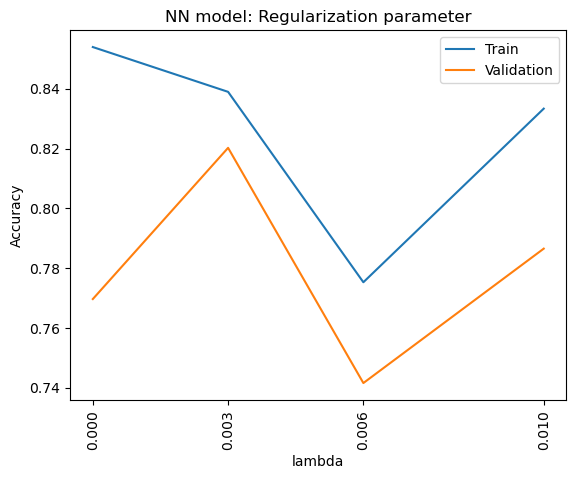

In [ ]:
plt.plot(lambda_list, NN_train_accuracy_list, label='Train')
plt.plot(lambda_list, NN_cv_accuracy_list, label='Validation')
plt.xticks(lambda_list, rotation=90);
plt.legend();
plt.xlabel('lambda')
plt.ylabel('Accuracy')
plt.title('NN model: Regularization parameter');

In [ ]:
NN_model = NN_models[1]

y_train_nn = Binary_sigmoid_predict(NN_model, X_train_nn)
y_cv_nn = Binary_sigmoid_predict(NN_model, X_cv_nn)
y_test_nn = Binary_sigmoid_predict(NN_model, X_test_nn)

acc_train_nn = accuracy_score(y_train, y_train_nn)
acc_cv_nn = accuracy_score(y_cv, y_cv_nn)
acc_test_nn = accuracy_score(y_test, y_test_nn)


print('\033[1m Model: Neural Network \033[0m')
print('------------------------------------------------------')
print(f'Accuracy score of the train set: {acc_train_nn:.3f}')
print(f'Accuracy score of the validation set: {acc_cv_nn:.3f}')
print(f'Accuracy score of the test set: {acc_test_nn:.3f}')


 Model: Neural Network 
------------------------------------------------------
Accuracy score of the train set: 0.839
Accuracy score of the validation set: 0.820
Accuracy score of the test set: 0.860


### 6.2 Arquitecture 2

Epoch 1/150
17/17 [==============================] - 1s 2ms/step - loss: 0.6943
Epoch 2/150
17/17 [==============================] - 0s 1ms/step - loss: 0.6203
Epoch 3/150
17/17 [==============================] - 0s 2ms/step - loss: 0.6010
Epoch 4/150
17/17 [==============================] - 0s 1ms/step - loss: 0.5971
Epoch 5/150
17/17 [==============================] - 0s 1ms/step - loss: 0.5916
Epoch 6/150
17/17 [==============================] - 0s 1ms/step - loss: 0.5883
Epoch 7/150
17/17 [==============================] - 0s 1ms/step - loss: 0.5845
Epoch 8/150
17/17 [==============================] - 0s 2ms/step - loss: 0.5803
Epoch 9/150
17/17 [==============================] - 0s 2ms/step - loss: 0.5757
Epoch 10/150
17/17 [==============================] - 0s 1ms/step - loss: 0.5763
Epoch 11/150
17/17 [==============================] - 0s 1ms/step - loss: 0.5718
Epoch 12/150
17/17 [==============================] - 0s 2ms/step - loss: 0.5641
Epoch 13/150
17/17 [=================

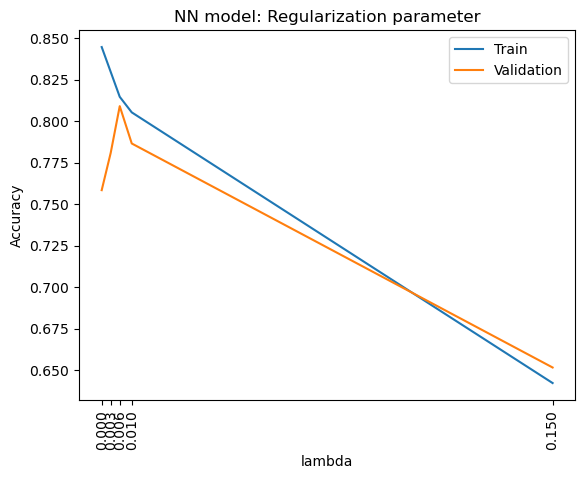

In [ ]:
lambda_list = [0, 0.003, 0.006, 0.01]

NN_train_accuracy_list = []
NN_cv_accuracy_list = []
NN_models = []
for lambda_ in lambda_list:
    NN_model = Sequential([
        tf.keras.Input(shape=(X_train.shape[1],)),
        Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_), name='L1'),
        Dense(12, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_), name='L2'),
        Dense(12, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_), name='L3'),
        Dense(12, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_), name='L4'),
        Dense(1, activation='linear', name='L_out')
    ])
    NN_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss=BinaryCrossentropy(from_logits=True))
    NN_model.fit(X_train_nn, y_train, epochs = 150)

    y_train_nn = Binary_sigmoid_predict(NN_model, X_train_nn)
    y_cv_nn = Binary_sigmoid_predict(NN_model, X_cv_nn)

    acc_train_nn = accuracy_score(y_train, y_train_nn)
    acc_cv_nn = accuracy_score(y_cv, y_cv_nn)

    NN_train_accuracy_list.append(acc_train_nn)
    NN_cv_accuracy_list.append(acc_cv_nn)
    NN_models.append(NN_model)

plt.plot(lambda_list, NN_train_accuracy_list, label='Train')
plt.plot(lambda_list, NN_cv_accuracy_list, label='Validation')
plt.xticks(lambda_list, rotation=90);
plt.legend();
plt.xlabel('lambda')
plt.ylabel('Accuracy')
plt.title('NN model: Regularization parameter');


In [ ]:
NN_model = NN_models[2]

y_train_nn = Binary_sigmoid_predict(NN_model, X_train_nn)
y_cv_nn = Binary_sigmoid_predict(NN_model, X_cv_nn)
y_test_nn = Binary_sigmoid_predict(NN_model, X_test_nn)

acc_train_nn = accuracy_score(y_train, y_train_nn)
acc_cv_nn = accuracy_score(y_cv, y_cv_nn)
acc_test_nn = accuracy_score(y_test, y_test_nn)


print('\033[1m Model: Neural Network \033[0m')
print('------------------------------------------------------')
print(f'Accuracy score of the train set: {acc_train_nn:.3f}')
print(f'Accuracy score of the validation set: {acc_cv_nn:.3f}')
print(f'Accuracy score of the test set: {acc_test_nn:.3f}')

 Model: Neural Network 
------------------------------------------------------
Accuracy score of the train set: 0.815
Accuracy score of the validation set: 0.809
Accuracy score of the test set: 0.827


### 6.3 Arquitecture 3

Epoch 1/150
17/17 [==============================] - 1s 2ms/step - loss: 0.7174
Epoch 2/150
17/17 [==============================] - 0s 2ms/step - loss: 0.6114
Epoch 3/150
17/17 [==============================] - 0s 2ms/step - loss: 0.5971
Epoch 4/150
17/17 [==============================] - 0s 2ms/step - loss: 0.5875
Epoch 5/150
17/17 [==============================] - 0s 2ms/step - loss: 0.5740
Epoch 6/150
17/17 [==============================] - 0s 2ms/step - loss: 0.5679
Epoch 7/150
17/17 [==============================] - 0s 2ms/step - loss: 0.5688
Epoch 8/150
17/17 [==============================] - 0s 2ms/step - loss: 0.5570
Epoch 9/150
17/17 [==============================] - 0s 2ms/step - loss: 0.5619
Epoch 10/150
17/17 [==============================] - 0s 2ms/step - loss: 0.5411
Epoch 11/150
17/17 [==============================] - 0s 2ms/step - loss: 0.5301
Epoch 12/150
17/17 [==============================] - 0s 2ms/step - loss: 0.5316
Epoch 13/150
17/17 [=================

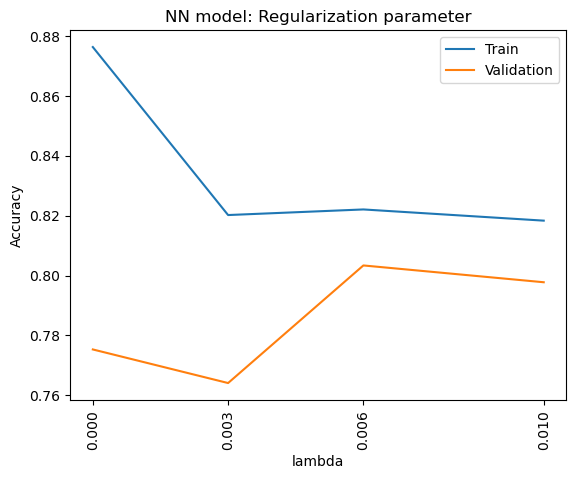

In [ ]:
lambda_list = [0, 0.003, 0.006, 0.01]

NN_train_accuracy_list = []
NN_cv_accuracy_list = []
NN_models = []
for lambda_ in lambda_list:
    NN_model = Sequential([
        tf.keras.Input(shape=(X_train.shape[1],)),
        Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_), name='L1'),
        Dense(24, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_), name='L2'),
        Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_), name='L3'),
        Dense(12, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_), name='L4'),
        Dense(1, activation='linear', name='L_out')
    ])
    NN_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss=BinaryCrossentropy(from_logits=True))
    NN_model.fit(X_train_nn, y_train, epochs = 150)

    y_train_nn = Binary_sigmoid_predict(NN_model, X_train_nn)
    y_cv_nn = Binary_sigmoid_predict(NN_model, X_cv_nn)

    acc_train_nn = accuracy_score(y_train, y_train_nn)
    acc_cv_nn = accuracy_score(y_cv, y_cv_nn)

    NN_train_accuracy_list.append(acc_train_nn)
    NN_cv_accuracy_list.append(acc_cv_nn)
    NN_models.append(NN_model)

plt.plot(lambda_list, NN_train_accuracy_list, label='Train')
plt.plot(lambda_list, NN_cv_accuracy_list, label='Validation')
plt.xticks(lambda_list, rotation=90);
plt.legend();
plt.xlabel('lambda')
plt.ylabel('Accuracy')
plt.title('NN model: Regularization parameter');

In [ ]:
NN_model = NN_models[2]

y_train_nn = Binary_sigmoid_predict(NN_model, X_train_nn)
y_cv_nn = Binary_sigmoid_predict(NN_model, X_cv_nn)
y_test_nn = Binary_sigmoid_predict(NN_model, X_test_nn)

acc_train_nn = accuracy_score(y_train, y_train_nn)
acc_cv_nn = accuracy_score(y_cv, y_cv_nn)
acc_test_nn = accuracy_score(y_test, y_test_nn)


print('\033[1m Model: Neural Network \033[0m')
print('------------------------------------------------------')
print(f'Accuracy score of the train set: {acc_train_nn:.3f}')
print(f'Accuracy score of the validation set: {acc_cv_nn:.3f}')
print(f'Accuracy score of the test set: {acc_test_nn:.3f}')

 Model: Neural Network 
------------------------------------------------------
Accuracy score of the train set: 0.822
Accuracy score of the validation set: 0.803
Accuracy score of the test set: 0.832
